In [1]:
from pandas import read_csv, read_feather, concat
import numpy as np

In [2]:
def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
    radius = 6371

    dLat = (lat2-lat1) * np.pi / 180
    dLng = (lng2-lng1) * np.pi / 180

    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180

    val = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLng/2)\
    * np.sin(dLng/2) * np.cos(lat1) * np.cos(lat2)    
    ang = 2 * np.arctan2(np.sqrt(val), np.sqrt(1-val))
    return radius * ang

In [3]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['jfk_dist'] = concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    dataset['ewr_dist'] = concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    dataset['lga_dist'] = concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return dataset

In [4]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)
print(test_df.shape)
test_df.head()

(9914, 7)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


In [5]:
lng1min = test_df.pickup_longitude.min()
lng2min = test_df.dropoff_longitude.min()
lat1min = test_df.pickup_latitude.min()
lat2min = test_df.dropoff_latitude.min()
#
lng1max = test_df.pickup_longitude.max()
lng2max = test_df.dropoff_longitude.max()
lat1max = test_df.pickup_latitude.max()
lat2max = test_df.dropoff_latitude.max()

In [73]:
%%time
# Read a subsample (train1) of the original dataset with 55M rows
# It was obtained ramdomly using the command line subsample task:
# >subsample --reservoir -n 2000000 train.csv -r > train1.csv
train_df = read_feather('tmp/train1.feather')
train_df.head()

CPU times: user 37.5 ms, sys: 28.5 ms, total: 66 ms
Wall time: 64.4 ms


In [74]:
def transform(train_df):
    
    # Remove missing values
    train_df = train_df.dropna(how = 'any', axis = 'rows')

    # Remove absurd passenger_count
    train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]

    # Remove negative and extreme fare_amount values
    train_df = train_df[(train_df['fare_amount'] >= 2.5) & (train_df['fare_amount'] <= 200)]
    print('Maximum fare_amount: %.1f' % train_df['fare_amount'].max())

    # Remove no displacements
    train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude'])]
    train_df = train_df[(train_df['pickup_longitude'] != train_df['dropoff_longitude'])]

    # Remove absurd displacements
    train_df = train_df[(train_df['pickup_longitude'] >= lng1min) & (train_df['pickup_longitude'] <= lng1max)]
    train_df = train_df[(train_df['dropoff_longitude'] >= lng2min) & (train_df['dropoff_longitude'] <= lng2max)]
    train_df = train_df[(train_df['pickup_latitude'] >= lat1min) & (train_df['pickup_latitude'] <= lat1max)]
    train_df = train_df[(train_df['dropoff_latitude'] >= lat2min) & (train_df['dropoff_latitude'] <= lat2max)]

    # Create new features - distance
    train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                                train_df['dropoff_latitude'], train_df['dropoff_longitude'])
    train_df = train_df[train_df['dist'] <= 100]

    # Create new features - dayofweek,hour,month,year
    train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek.astype('uint8')
    train_df['hour'] = train_df['pickup_datetime'].dt.hour.astype('uint8')
    train_df['month'] = train_df['pickup_datetime'].dt.month.astype('uint8')
    train_df['year'] = train_df['pickup_datetime'].dt.year.astype('uint16')

    # Add minimum distances to the airports
    add_airport_dist(train_df)
    
    # Create dataframes for the two periods
    P1 = train_df[(train_df['pickup_datetime'] < '2012-09-01')]
    P1 = P1.drop(['pickup_datetime'], axis=1)
    print(P1.shape)
    P2 = train_df.loc[(train_df['pickup_datetime'] >= '2012-09-01')]
    P2 = P2.drop(['pickup_datetime'], axis=1)
    print(P2.shape)

    # Save memory
    print(train_df.shape)
    print('Maximum ride distance: %.1f' % train_df['dist'].max())
    del train_df
    return P1,P2

In [75]:
P1, P2 = transform(train_df)

Maximum fare_amount: 200.0
(1099583, 14)
(827716, 14)
(1927299, 15)
Maximum ride distance: 99.9


In [45]:
P1.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,dayofweek,hour,month,year,jfk_dist,ewr_dist,lga_dist
2,4.50,-74.002281,40.726578,-74.009583,40.723598,2,0.698792,5,22,8,2012,21.168234,13.843294,12.290257
3,14.50,-73.932800,40.758900,-73.995003,40.736599,1,5.797079,5,23,10,2011,18.546139,15.431745,5.463948
6,4.10,-73.970421,40.759384,-73.961517,40.760220,1,0.755629,2,21,11,2010,20.409483,18.281992,7.722772
9,4.10,-73.972519,40.749611,-73.977600,40.745651,2,0.614066,1,14,8,2012,20.390841,17.148228,8.957843
10,26.65,-73.862633,40.768875,-73.986191,40.749622,1,10.624672,0,16,3,2009,16.002337,16.633610,1.254210


## Model P1

In [40]:
from sklearn.model_selection import train_test_split

X = P1.iloc[:,1:].values
y = np.log10(P1.iloc[:,0].values)

seed = 55

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.1, random_state=seed)

In [41]:
%%time
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

modelP1=xgb.XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.05,
                         max_depth=8,
                         min_child_weight=1,
                         n_estimators=500,
                         objective= "reg:linear",
                         nthread=-1)

modelP1.fit(X_train,y_train)
y_pred = modelP1.predict(X_test)
print('RMSE before gridsearch: %.4f' % np.sqrt(mean_squared_error(y_pred,y_test)))

RMSE before gridsearch: 0.0956
CPU times: user 33min 40s, sys: 1min 25s, total: 35min 6s
Wall time: 7min 55s


### GridSearchCV - Model 1

In [ ]:
params = {'max_depth':[10,15],
          'n_estimators':[50],
          'min_child_weight':range(1,3),
          'learning_rate':[.1,.01],
          'colsample_bytree':[.9],
          'gamma':[0,1]}

In [ ]:
from sklearn.model_selection import GridSearchCV

#with the parameter nthread we specify XGBoost for parallelisation
modelP1 = xgb.XGBRegressor(objective= "reg:linear",nthread=-1)

# Grid search cross-validation 
M1=GridSearchCV(estimator=modelP1,param_grid=params,n_jobs=-1,
                 scoring='neg_mean_absolute_error',verbose=True)

In [ ]:
%%time
M1.fit(X_train,y_train)
print(M1.best_params_)
y_pred = M1.predict(X_test)
print('RMSE after gridsearch: %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)))

## Model P2

In [76]:
from sklearn.model_selection import train_test_split

X = P2.iloc[:,1:].values
y = np.log10(P2.iloc[:,0].values)

seed = 55

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.1, random_state=seed)

In [77]:
%%time
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

modelP2=xgb.XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.05,
                         max_depth=8,
                         min_child_weight=1,
                         n_estimators=500,
                         objective= "reg:linear",
                         nthread=-1)

modelP2.fit(X_train,y_train)
y_pred = modelP2.predict(X_test)
print('RMSE before gridsearch: %.4f' % np.sqrt(mean_squared_error(y_pred,y_test)))

RMSE before gridsearch: 0.0911
CPU times: user 22min 26s, sys: 1min 7s, total: 23min 34s
Wall time: 5min 32s


### GridSearchCV - Model 2

In [ ]:
params = {'max_depth':[6,8,10],
          'n_estimators':[100],
          'min_child_weight':range(1,3),
          'learning_rate':[.1,.01,.001],
          'colsample_bytree':[.8,.9,1],
          'gamma':[0,1]}

In [ ]:
from sklearn.model_selection import GridSearchCV

#with the parameter nthread we specify XGBoost for parallelisation
modelP2 = xgb.XGBRegressor(objective= "reg:linear",nthread=-1)

# Grid search cross-validation 
M2=GridSearchCV(estimator=modelP2,param_grid=params,n_jobs=-1,
                 scoring='neg_mean_absolute_error',verbose=True)

In [ ]:
%%time
M2.fit(X_train,y_train)
print(M2.best_params_)
y_pred = M2.predict(X_test)
print('RMSE after gridsearch: %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)))

## Make predictions on the test set

In [78]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)

test_df['dist'] = distance(test_df['pickup_latitude'], test_df['pickup_longitude'],
                           test_df['dropoff_latitude'], test_df['dropoff_longitude'])

print('Minimum ride distance: %.1f' % test_df['dist'].min())
print('Maximum ride distance: %.1f' % test_df['dist'].max())

test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
test_df['hour'] = test_df['pickup_datetime'].dt.hour #.astype('uint8')
test_df['month'] = test_df['pickup_datetime'].dt.month #.astype('uint8')
test_df['year'] = test_df['pickup_datetime'].dt.year #.astype('uint8')

# Add minimum distances to the airports
add_airport_dist(test_df)

#test_df = test_df.drop(['passenger_count'], axis=1)
test_df.head()

Minimum ride distance: 0.0
Maximum ride distance: 100.0


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,dayofweek,hour,month,year,jfk_dist,ewr_dist,lga_dist
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,1,13,1,2015,20.630787,16.776178,8.611599
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,1,13,1,2015,19.647702,15.217920,11.446400
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,5,11,10,2011,20.652459,16.988793,9.656367
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,5,21,12,2012,21.747868,16.391035,9.200895
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,5,21,12,2012,21.167442,16.235246,7.989082


In [79]:
X_testF = test_df.iloc[:,2:].values
y_predFP1 = 10**(modelP1.predict(X_testF).round(4))
y_predFP2 = 10**(modelP2.predict(X_testF).round(4))

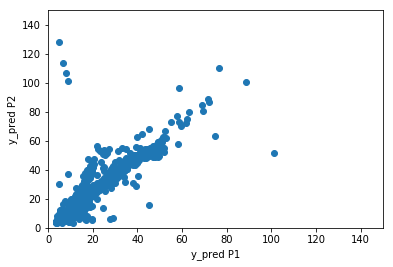

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_predFP1, y_predFP2)
plt.xlabel('y_pred P1')
plt.ylabel('y_pred P2')
plt.xlim(0,150)
plt.ylim(0,150)
plt.show()

In [81]:
from pandas import DataFrame

submission = DataFrame({'key': test_df.key, 'fare_amountP1': y_predFP1,
                        'fare_amountP2': y_predFP2},
                       columns = ['key', 'fare_amountP1', 'fare_amountP2'])

submission['fare_amount'] = np.where(test_df['pickup_datetime'] < '2012-09-01',
                                     submission['fare_amountP1'],
                                     submission['fare_amountP2'])

submission = submission.drop(['fare_amountP1','fare_amountP2'], axis=1)
submission.to_csv('submission.csv', index = False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.576349
1,2015-01-27 13:08:24.0000003,10.744843
2,2011-10-08 11:53:44.0000002,4.420791
3,2012-12-01 21:12:12.0000002,9.013637
4,2012-12-01 21:12:12.0000003,16.010317


## Submissions

In [ ]:
from pandas import read_csv

In [ ]:
import os
import glob

for filepath in glob.glob(os.path.join('/Users/vbordalo/DataScience/Kaggle/TaxiNYC', 'submission*.csv')):
    with open(filepath) as f:
        content = f.read()

In [ ]:
sub1 = read_csv('submission1.csv')
sub2 = read_csv('submission2.csv')
sub3 = read_csv('submission3.csv')
sub4 = read_csv('submission4.csv')
sub5 = read_csv('submission5.csv')
sub6 = read_csv('submission6.csv')
sub7 = read_csv('submission7.csv')
sub8 = read_csv('submission8.csv')
sub9 = read_csv('submission9.csv')
sub10 = read_csv('submission10.csv')
sub11 = read_csv('submission11.csv')

In [ ]:
rmse = [3.84524,
       3.64728,
       3.60249,
       3.46635,
       3.44016,
       3.43703,
       3.33139,
       3.27094,
       3.25232,
       3.21054,
       3.20225]

In [ ]:
dic = {'means':[sub1.fare_amount.mean(),
               sub2.fare_amount.mean(),
               sub3.fare_amount.mean(),
               sub4.fare_amount.mean(),
               sub5.fare_amount.mean(),
               sub6.fare_amount.mean(),
               sub7.fare_amount.mean(),
               sub8.fare_amount.mean(),
               sub9.fare_amount.mean(),
               sub10.fare_amount.mean(),
                sub11.fare_amount.mean()
              ],
      'stds':[sub1.fare_amount.std(),
             sub2.fare_amount.std(),
             sub3.fare_amount.std(),
             sub4.fare_amount.std(),
             sub5.fare_amount.std(),
             sub6.fare_amount.std(),
             sub7.fare_amount.std(),
             sub8.fare_amount.std(),
             sub9.fare_amount.std(),
             sub10.fare_amount.std(),
              sub11.fare_amount.std()
            ],
      'skews':[sub1.fare_amount.skew(),
              sub2.fare_amount.skew(),
              sub3.fare_amount.skew(),
              sub4.fare_amount.skew(),
              sub5.fare_amount.skew(),
              sub6.fare_amount.skew(),
              sub7.fare_amount.skew(),
              sub8.fare_amount.skew(),
              sub9.fare_amount.skew(),
              sub10.fare_amount.skew(),
               sub11.fare_amount.skew()
             ],
      'kurts':[sub1.fare_amount.kurt(),
              sub2.fare_amount.kurt(),
              sub3.fare_amount.kurt(),
              sub4.fare_amount.kurt(),
              sub5.fare_amount.kurt(),
              sub6.fare_amount.kurt(),
              sub7.fare_amount.kurt(),
              sub8.fare_amount.kurt(),
              sub9.fare_amount.kurt(),
              sub10.fare_amount.kurt(),
               sub11.fare_amount.kurt()
             ],
      'rmse':rmse
      }

In [ ]:
from pandas import DataFrame
df = DataFrame(dic)

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df.rmse,df.means)
plt.xlim(2.6,4)
plt.show()
plt.scatter(df.rmse,df.stds)
plt.xlim(2.6,4)
plt.show()
plt.scatter(df.rmse,df.skews)
plt.xlim(2.6,4)
plt.show()
plt.scatter(df.rmse,df.kurts)
plt.xlim(2.6,4)
plt.show()